OBJECTIVE:
Perform Naive-Bayes classification using 5 fold cross validation, on Amazon Fine food reviews to predict the polarity of the review as either 'Positive' or 'Negative'. The NB is to be performed on text vectorization models such as:
1)Bag of Words
2)TF-IDF

Also come up with the optimal 'Alpha' using the 5-fold cross validation technique and use the same to predict the future TEST data and determine the accuracy, Precision, Recall,F-1 score and confusion matrix for the same. 

In [192]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import cross_validation
import warnings
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

warnings.filterwarnings("ignore")
# =============================================================================================

In [193]:
#Loading the final dataset of AFF after Data preprocessing and removing duplicates done previously in TSNE

con = sqlite3.connect('C:\\Users\\rahul\\Desktop\\AI COURSE\\Amazon Fine food\\amazon-fine-food-reviews (1)\\final.sqlite')

In [194]:
data = pd.read_sql_query("""SELECT * FROM REVIEWS """,con)
print(data.shape)

#check no of Positive and negative reviews present
data['Score'].value_counts()

#Performing Time based slicing on the data
sorted_data = data.sort_values('Time')

#since facing memory issue just taking 20k data points
sample_data = sorted_data.sample(n=60000)

print(sample_data.shape)


(364171, 12)
(60000, 12)


In [195]:
label = sample_data['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(sample_data, label, test_size=0.3, random_state=0)

type(sample_data)

pandas.core.frame.DataFrame

BOW Model:

In [196]:
#Bag of words using Scikit learn
count_vect = CountVectorizer()
vocab = count_vect.fit(X_train['CleanedText'].values)
type(vocab)

#Using the vocab obtained in train to vectorize both train and test data
X_train = vocab.transform(X_train['CleanedText'].values)
X_test = vocab.transform(X_test['CleanedText'].values)

In [208]:
from sklearn.naive_bayes import MultinomialNB

#function to find the optimal alpha in NB for 5 fold cross validation
def find_optimal_alpha(x,y,n):
    # creating a list of alpha for NB
    alpha_list = [0.00001,.0001,.001,.01,.1,1,10,100,1000,10000]
    
    # empty list that will hold cv scores
    cv_scores = []

# perform 5-fold cross validation 

#dropping the prior probabilities as we have higly imbalanced data
    for alpha in alpha_list:
        clf = MultinomialNB(alpha=alpha, fit_prior=False)
        scores = cross_val_score(clf, x, y, cv=n, scoring='accuracy')
        cv_scores.append(scores.mean())

# changing to misclassification error (error = 1 - accuracy)
    MSE = [1 - x for x in cv_scores]

# determining best k
    optimal_alpha = alpha_list[MSE.index(min(MSE))]
    print('\nThe optimal value of alpha is %f.' % optimal_alpha)

# plot misclassification error vs k 
    plt.plot(alpha_list, MSE)

    for xy in zip(alpha_list, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Value of alpha ')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each alpha value is : ", np.round(MSE,3))
    return optimal_alpha
    
    # ============================== Naive Bayes with alpha = optimal_alpha ===============================================
# instantiate learning model k = optimal_k

#function to predict the label of test data and return the same as list 
def pred_test_data(x_tr,y_tr,x_tst,y_tst,optimal_alpha,model):
    NB_optimal = MultinomialNB(alpha=optimal_alpha, fit_prior=False)

    # fitting the model
    NB_optimal.fit(x_tr, y_tr)

    # predict the response
    pred = NB_optimal.predict(x_tst)
    
    # evaluate accuracy
    acc = accuracy_score(y_tst, pred) * 100
    print('\nThe accuracy of the NB classifier for alpha = %d is %f%%' % (optimal_alpha, acc))
    
    feat_imp = NB_optimal.feature_log_prob_
    
    #sort the feature based on log probabilities for each class (since log is a monotonic function)
    neg_class_prob_sorted = (-NB_optimal.feature_log_prob_[0, :]).argsort()
    pos_class_prob_sorted = (-NB_optimal.feature_log_prob_[1, :]).argsort()

    print("The most important features for negative class are :", np.take(model.get_feature_names(), neg_class_prob_sorted[:10]))
    print("The most important features for positive class are :", np.take(model.get_feature_names(), pos_class_prob_sorted[:10]))

    return pred

#Function to create Confusion matrix creation and plotting the same
def confusion_heatmap(x,y):
    cnf_mat = confusion_matrix(x,y)
    print("Confusion matrix is : " ,cnf_mat )
    print("The True Positive value is:  ",(cnf_mat[1][1]))
    print("The True Negative value is:  ",(cnf_mat[0][0]))
    print("The False Positive value is:  ",(cnf_mat[1][0]))
    print("The False Negative value is:  ",(cnf_mat[0][1]))
    sns.heatmap(cnf_mat,cbar_kws={'label': 'colorbar title'},cmap='YlGnBu',linewidths=2, linecolor='yellow')
    
    
def metric_score(x,y):
    print("The precision score for our model is: ", precision_score(x,y)) 
    print("The f1 score for our model is: ", f1_score(x,y))
    print("The recall score for our model is: ", recall_score(x,y))
    print("The accuracy of our model is: ", accuracy_score(x,y))


The optimal value of alpha is 1.000000.


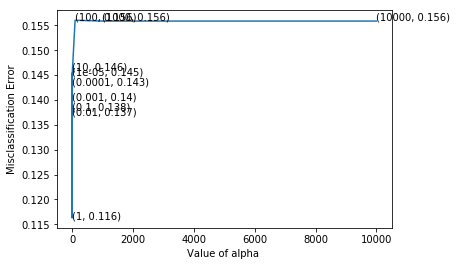

the misclassification error for each alpha value is :  [0.145 0.143 0.14  0.137 0.138 0.116 0.146 0.156 0.156 0.156]


In [205]:
opt_alpha = find_optimal_alpha(X_train,y_train,5)

In [206]:
y_pred = pred_test_data(X_train,y_train,X_test,y_test,opt_alpha,count_vect)
type(y_pred)


The accuracy of the NB classifier for alpha = 1 is 89.516667%
The most important features for negative class are : ['not' 'tast' 'like' 'product' 'one' 'flavor' 'would' 'tri' 'use' 'good']
The most important features for positive class are : ['not' 'like' 'tast' 'good' 'love' 'flavor' 'great' 'use' 'one' 'product']


numpy.ndarray

Confusion matrix is :  [[ 2110   721]
 [ 1166 14003]]
The True Positive value is:   14003
The True Negative value is:   2110
The False Positive value is:   1166
The False Negative value is:   721


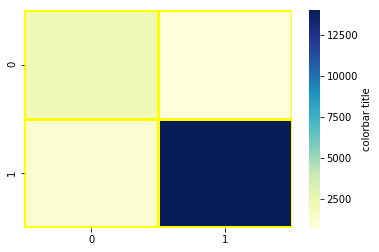

In [209]:
confusion_heatmap(y_test,y_pred)

In [210]:
#determining metrics precision,recall,f-1 scores for our model
# print(y_test.shape)
# print(type(y_pred))
# print(type(y_test))
# metric_score(y_test,y_pred)

encoder = preprocessing.LabelEncoder()
y_en_test = encoder.fit_transform(y_test)
y_en_pred = encoder.fit_transform(y_pred)
print(y_en_pred)
metric_score(y_en_test,y_en_pred)

[1 1 1 ... 1 1 1]
The precision score for our model is:  0.9510323281716925
The f1 score for our model is:  0.936874853644666
The recall score for our model is:  0.9231327048585932
The accuracy of our model is:  0.8951666666666667


Conclusion:
1.Naive Bayes using 5-fold validation was performed on a sample dataset of AFF for Bag of words.
2.We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
3.The optimal alpha in was computed to be 1.
4.Confusion matrix was plotted for the same. We got True Negative value of 2110 and True Positive value of 14003. we also get a high false positive value of 1166 meaning more misclassification of the negative class.
5.The accuracy,precision, recall and f1 scores are 89.51 % , 95.10%, 92.31% and 93.68 % respectively. This means that we are performing remarkabely well in Postive class classification.
6.Also NB helps us in getting the feature importance, we got the top 10 words that helped us in classifying a given point for both classes.They were:
Positive--> ['not' 'like' 'tast' 'good' 'love' 'flavor' 'great' 'use' 'one' 'product']
Negative--> ['not' 'tast' 'like' 'product' 'one' 'flavor' 'would' 'tri' 'use' 'good']
7.Since there were memory issues, only a sample 60k dataset had been chosen.

TF-IDF Model:

In [211]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(sample_data, label, test_size=0.3, random_state=0)
#Converting text into vector using tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab = tf_idf_vect.fit(X_train['CleanedText'].values)
X_train = vocab.transform(X_train['CleanedText'].values)
X_test = vocab.transform(X_test['CleanedText'].values)

type(X_train)

scipy.sparse.csr.csr_matrix


The optimal value of alpha is 0.100000.


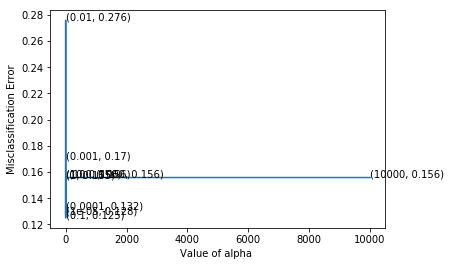

the misclassification error for each alpha value is :  [0.128 0.132 0.17  0.276 0.125 0.155 0.156 0.156 0.156 0.156]


In [212]:
opt_alpha = find_optimal_alpha(X_train,y_train,5)

In [213]:
y_pred = pred_test_data(X_train,y_train,X_test,y_test,opt_alpha,tf_idf_vect)
type(y_pred)


The accuracy of the NB classifier for alpha = 0 is 89.172222%
The most important features for negative class are : ['not' 'tast' 'like' 'product' 'would' 'flavor' 'coffe' 'one' 'tri' 'buy']
The most important features for positive class are : ['love' 'great' 'like' 'good' 'tast' 'not' 'tea' 'coffe' 'flavor'
 'product']


numpy.ndarray

Confusion matrix is :  [[  987  1844]
 [  105 15064]]
The True Positive value is:   15064
The True Negative value is:   987
The False Positive value is:   105
The False Negative value is:   1844


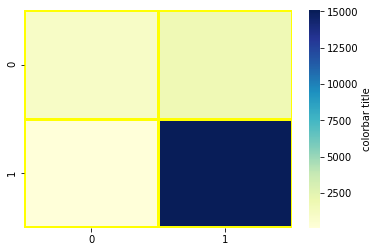

In [214]:
confusion_heatmap(y_test,y_pred)

In [215]:
#determining metrics precision,recall,f-1 scores for our model
# print(y_test.shape)
# print(type(y_pred))
# print(type(y_test))
# metric_score(y_test,y_pred)

encoder = preprocessing.LabelEncoder()
y_en_test = encoder.fit_transform(y_test)
y_en_pred = encoder.fit_transform(y_pred)
print(y_en_pred)
metric_score(y_en_test,y_en_pred)

[1 1 1 ... 1 1 1]
The precision score for our model is:  0.890939200378519
The f1 score for our model is:  0.939239953861022
The recall score for our model is:  0.9930779880018459
The accuracy of our model is:  0.8917222222222222


Conclusion:
1.Naive Bayes using 5-fold validation was performed on a sample dataset of AFF for TF-IDF.
2.We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
3.The optimal alpha in was computed to be .1.
4.Confusion matrix was plotted for the same. We got True Negative value of 987 and True Positive value of 15064. we also get a low false positive value of 105 meaning lesser misclassification of the postive class.
5.The accuracy,precision, recall and f1 scores are 89.17 % , 89.09%, 99.30% and 93.92 % respectively. It can be seen that we are performing better in classifing postive class than negative class.
6.Also NB helps us in getting the feature importance, we got the top 10 words that helped us in classifying a given point for both classes.They were:
Positive--> ['not' 'like' 'tast' 'good' 'love' 'flavor' 'great' 'use' 'one' 'product']
Negative--> ['not' 'tast' 'like' 'product' 'would' 'flavor' 'coffe' 'one' 'tri' 'buy']
7.Since there were memory issues, only a sample 60k dataset had been chosen.

In [216]:
from prettytable import PrettyTable
    
x = PrettyTable(["METRIC", "B.O.W", "TF-IDF"])

x.add_row(["Alpha",1, .1])
x.add_row(["True Positive",14003, 15064])
x.add_row(["True Negative",2110, 987])
x.add_row(["Accuracy",89.51, 89.17])
x.add_row(["Precision",95.10, 89.09])
x.add_row(["Recall",92.31, 99.30])
x.add_row(["F1 Scores",93.68, 93.92])

print(x)

+---------------+-------+--------+
|     METRIC    | B.O.W | TF-IDF |
+---------------+-------+--------+
|     Alpha     |   1   |  0.1   |
| True Positive | 14003 | 15064  |
| True Negative |  2110 |  987   |
|    Accuracy   | 89.51 | 89.17  |
|   Precision   |  95.1 | 89.09  |
|     Recall    | 92.31 |  99.3  |
|   F1 Scores   | 93.68 | 93.92  |
+---------------+-------+--------+
